In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Integrated_Dataset_Harini_Mukesh.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.head()


,DateTime,Junction,Vehicles,ID,timestamp,temperature,humidity,precipitation,windspeed,event_flag,event_type,date,hour,dayofweek
0,11/1/2015 0:00,1,15,20151101001,2015-11-01 00:00:00,24.4,96,0.2,10.1,0,none,11/1/2015,0,6
1,11/1/2015 1:00,1,13,20151101011,2015-11-01 01:00:00,24.4,95,0.3,10.6,0,none,11/1/2015,1,6
2,11/1/2015 2:00,1,10,20151101021,2015-11-01 02:00:00,25.1,92,0.2,10.4,0,none,11/1/2015,2,6
3,11/1/2015 3:00,1,7,20151101031,2015-11-01 03:00:00,25.9,88,0.5,11.0,0,none,11/1/2015,3,6
4,11/1/2015 4:00,1,9,20151101041,2015-11-01 04:00:00,27.0,82,0.2,10.3,0,none,11/1/2015,4,6


TASK 1 – Peak Hour Identification & Pattern Analysis
1️⃣ Congestion metrics (per junction, per hour)

We’ll use average Vehicles per hour as congestion metric.

In [2]:
# Average vehicles per hour per junction
hourly_junction = (
    df.groupby(["Junction", "hour"])
      .agg(avg_vehicles=("Vehicles", "mean"),
           std_vehicles=("Vehicles", "std"),
           count=("Vehicles", "size"))
      .reset_index()
)

hourly_junction.head()


,Junction,hour,avg_vehicles,std_vehicles,count
0,1,0,45.824590,18.234570,610
1,1,1,39.187192,15.564629,609
2,1,2,33.939245,13.701635,609
3,1,3,29.456486,12.094549,609
4,1,4,25.681445,10.422190,609


2️⃣ Identify peak hours per junction

Top congested hours per junction:

In [3]:
# Top 3 peak hours per junction
peak_hours = (
    hourly_junction
    .sort_values(["Junction", "avg_vehicles"], ascending=[True, False])
    .groupby("Junction")
    .head(3)
)

peak_hours


,Junction,hour,avg_vehicles,std_vehicles,count
19,1,19,58.845649,24.972863,609
20,1,20,57.448276,24.033509,609
12,1,12,57.307061,25.386473,609
44,2,20,18.075534,8.629673,609
43,2,19,17.885057,8.786761,609
45,2,21,17.243021,8.030783,609
68,3,20,20.201970,18.961793,609
67,3,19,19.131363,14.770698,609
69,3,21,18.729064,15.676536,609
84,4,12,10.219780,3.917103,182


In [4]:
for junc in sorted(df["Junction"].unique()):
    sub = peak_hours[peak_hours["Junction"] == junc]
    print(f"\nJunction {junc} – Peak hours:")
    for _, r in sub.iterrows():
        print(f"  Hour {int(r['hour'])}: avg vehicles = {r['avg_vehicles']:.1f}")



Junction 1 – Peak hours:
  Hour 19: avg vehicles = 58.8
  Hour 20: avg vehicles = 57.4
  Hour 12: avg vehicles = 57.3

Junction 2 – Peak hours:
  Hour 20: avg vehicles = 18.1
  Hour 19: avg vehicles = 17.9
  Hour 21: avg vehicles = 17.2

Junction 3 – Peak hours:
  Hour 20: avg vehicles = 20.2
  Hour 19: avg vehicles = 19.1
  Hour 21: avg vehicles = 18.7

Junction 4 – Peak hours:
  Hour 12: avg vehicles = 10.2
  Hour 15: avg vehicles = 9.4
  Hour 14: avg vehicles = 9.2


3️⃣ Moving average / stability of peaks (optional but nice)

In [5]:
df = df.sort_values(["Junction", "timestamp"])
df["vehicles_ma_7d"] = (
    df.groupby("Junction")["Vehicles"]
      .transform(lambda s: s.rolling(24*7, min_periods=24).mean())
)


4️⃣ Weekday vs Weekend patterns

In [7]:
# Make sure timestamp is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Recreate time-based features safely
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek   # 0=Mon, 6=Sun
df["month"] = df["timestamp"].dt.month
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

print(df[["timestamp", "dayofweek", "hour", "is_weekend"]].head())


            timestamp  dayofweek  hour  is_weekend
0 2015-11-01 00:00:00          6     0           1
1 2015-11-01 01:00:00          6     1           1
2 2015-11-01 02:00:00          6     2           1
3 2015-11-01 03:00:00          6     3           1
4 2015-11-01 04:00:00          6     4           1


In [8]:
# Avg vehicles by junction, dayofweek, hour
dow_hour = (
    df.groupby(["Junction", "dayofweek", "hour"])
      .agg(avg_vehicles=("Vehicles", "mean"))
      .reset_index()
)

# Weekday vs weekend
wk_summary = (
    df.groupby(["Junction", "is_weekend", "hour"])
      .agg(avg_vehicles=("Vehicles", "mean"))
      .reset_index()
)

wk_summary.head()


,Junction,is_weekend,hour,avg_vehicles
0,1,0,0,48.135011
1,1,0,1,41.247706
2,1,0,2,35.967890
3,1,0,3,31.167431
4,1,0,4,27.162844


In [9]:
monthly = (
    df.groupby(["Junction", "month", "hour"])
      .agg(avg_vehicles=("Vehicles", "mean"))
      .reset_index()
)


6️⃣ Influence of weather & events

Simple correlation with Vehicles:

In [10]:
corr = df[["Vehicles", "temperature", "humidity",
           "precipitation", "windspeed", "event_flag"]].corr()

corr["Vehicles"].sort_values(ascending=False)


Vehicles         1.000000
humidity         0.102071
windspeed        0.002734
precipitation   -0.024997
temperature     -0.042064
event_flag      -0.064284
Name: Vehicles, dtype: float64

In [11]:
import statsmodels.api as sm

X = df[["temperature", "humidity", "precipitation", "windspeed", "event_flag", "hour"]]
X = sm.add_constant(X)
y = df["Vehicles"]

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               Vehicles   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     473.6
Date:                Tue, 09 Dec 2025   Prob (F-statistic):               0.00
Time:                        00:42:05   Log-Likelihood:            -2.1330e+05
No. Observations:               48220   AIC:                         4.266e+05
Df Residuals:                   48213   BIC:                         4.267e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.7363      1.752      0.420

### TASK 2 – Visualisation & Reporting
1️⃣ Visualisations

Here are 4 solid plots that are more than enough.

a) Line plot – Average vehicles by hour per junction

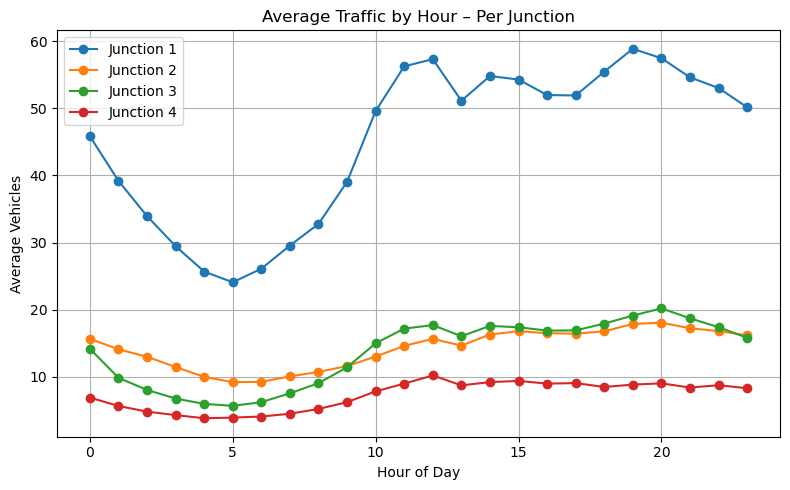

In [12]:
plt.figure(figsize=(8,5))
for junc in sorted(df["Junction"].unique()):
    subset = hourly_junction[hourly_junction["Junction"] == junc]
    plt.plot(subset["hour"], subset["avg_vehicles"], marker="o", label=f"Junction {junc}")
plt.xlabel("Hour of Day")
plt.ylabel("Average Vehicles")
plt.title("Average Traffic by Hour – Per Junction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


b) Heatmap – Day of week vs hour (for one junction)

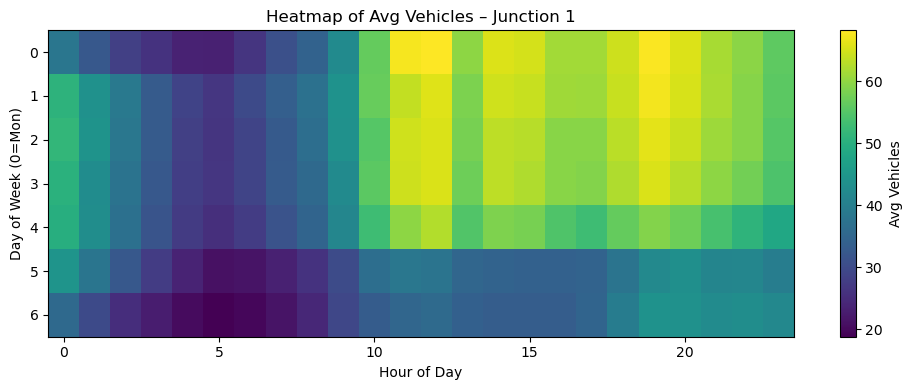

In [13]:
j = 1  # change 1,2,3,4 for each junction
sub = dow_hour[dow_hour["Junction"] == j]
pivot = sub.pivot(index="dayofweek", columns="hour", values="avg_vehicles")

plt.figure(figsize=(10,4))
plt.imshow(pivot, aspect="auto")
plt.colorbar(label="Avg Vehicles")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week (0=Mon)")
plt.title(f"Heatmap of Avg Vehicles – Junction {j}")
plt.tight_layout()
plt.show()


c) Boxplot – Weekday vs weekend peak hours

<Figure size 600x400 with 0 Axes>

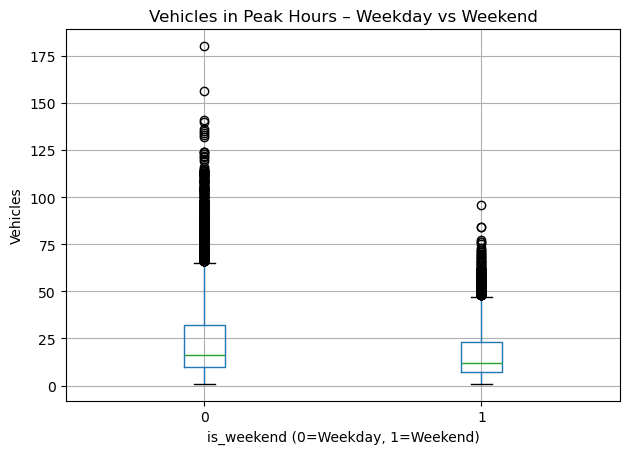

In [14]:
peak_hours_list = [7,8,9,17,18,19]  # typical peak candidates
sub_peak = df[df["hour"].isin(peak_hours_list)]

plt.figure(figsize=(6,4))
sub_peak.boxplot(column="Vehicles", by="is_weekend")
plt.suptitle("")
plt.title("Vehicles in Peak Hours – Weekday vs Weekend")
plt.xlabel("is_weekend (0=Weekday, 1=Weekend)")
plt.ylabel("Vehicles")
plt.tight_layout()
plt.show()


d) Scatter – Vehicles vs temperature / precipitation

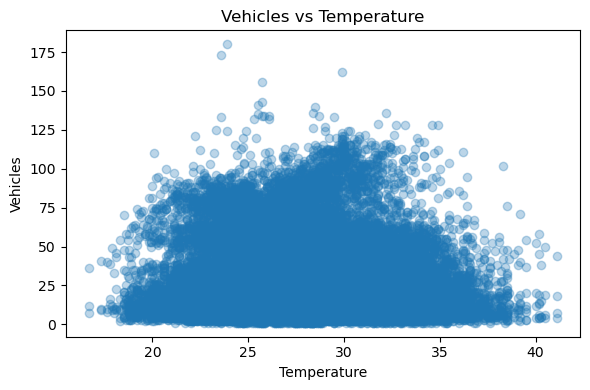

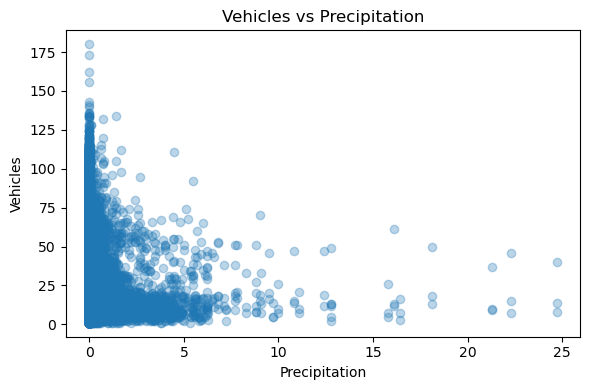

In [15]:
plt.figure(figsize=(6,4))
plt.scatter(df["temperature"], df["Vehicles"], alpha=0.3)
plt.xlabel("Temperature")
plt.ylabel("Vehicles")
plt.title("Vehicles vs Temperature")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(df["precipitation"], df["Vehicles"], alpha=0.3)
plt.xlabel("Precipitation")
plt.ylabel("Vehicles")
plt.title("Vehicles vs Precipitation")
plt.tight_layout()
plt.show()
